In [1]:
from conch.open_clip_custom import create_model_from_pretrained, tokenize, get_tokenizer
from conch.open_clip_custom.coca_model import CoCa, CoCaVisionCfg, CLIPTextCfg
import pandas as pd
import torch
import os
from PIL import Image
from pathlib import Path

# show all jupyter output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
root = Path('../').resolve()
os.chdir(root)


In [3]:


model, preprocess = create_model_from_pretrained(model_cfg='conch_ViT-B-16', 
                                                 checkpoint_path='./checkpoints/CONCH/pytorch_model.bin')
_ = model.eval()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device=device)
# vision_cfg = CoCaVisionCfg(
#     layers=12,
#     width=768,
#     num_heads=12,
#     mlp_ratio=4,
#     patch_size=16,
#     image_size=224,
#     attentional_pool_contrast=True,  
#     attentional_pool_caption=True,  
#     n_queries_contrast=1,
#     n_queries_caption=256,
#     attn_pooler_heads=8,
#     output_tokens=True  
# )
# 
# text_cfg = CLIPTextCfg(
#     context_length=77,
#     vocab_size=49408,
#     width=512,
#     heads=8,
#     layers=12,
#     proj='mlp',
# )
# 
# multimodal_cfg = CLIPTextCfg(
#     context_length=77,
#     vocab_size=49408,
#     width=512,
#     heads=8,
#     layers=12,
# )
# 
# 
# coca_model = CoCa(
#     embed_dim=512,
#     embed_dim_caption=512,
#     vision_cfg=vision_cfg,
#     text_cfg=text_cfg,
#     multimodal_cfg=multimodal_cfg,
# )
# 
# coca_model = coca_model.to(device)
# coca_model.eval()
df = pd.read_csv('./notebooks/captions.csv')

Open an image and preprocess it

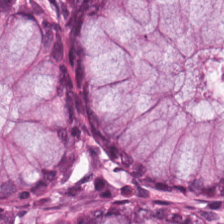

In [4]:
# files = os.listdir('./notebooks/patches_captions')
# first_image_path = os.path.join('./notebooks/patches_captions', files[0])
#image = Image.open('./NCT-CRC-HE-100K/TUM/TUM-AAGHMFGN.tif')
image = Image.open('./NCT-CRC-HE-100K/NORM/NORM-AEPAATAQ.tif')
#image = Image.open('./NCT-CRC-HE-100K/STR/STR-AADLAKYL.tif')
image_tensor = preprocess(image).unsqueeze(0).to(device)


image.resize((224, 224))
# def generate_caption(image_tensor):
#     with torch.no_grad():
#         if image_tensor.dim() == 3:
#             image_tensor = image_tensor.unsqueeze(0)
#         
#         image_latent, image_embs = coca_model._encode_image(image_tensor)
#         
#         current_tokens = torch.tensor([[1]], device=image_tensor.device)  # Assuming 1 is your start token
#         
#         for _ in range(30):
#           
#             output = coca_model(image_tensor, current_tokens, image_latent=image_latent, image_embs=image_embs, embed_cls=False)
#             logits = output['logits']
#             
#             next_token = logits[:, -1, :].argmax(dim=-1).unsqueeze(1)
#         
#             current_tokens = torch.cat([current_tokens, next_token], dim=1)
#         
#             if next_token.item() == 2:  
#                 break
#     
#     caption_text = tokenizer.decode(current_tokens[0].tolist())
#     return caption_text

Load tokenizer and specify some prompts.

In [5]:

tokenizer = get_tokenizer()
# generated_caption = generate_caption(image_tensor)
# print("Generated Caption:", generated_caption)

# prompt_and_captions = df['text'].tolist()
prompts = [
           'photomicrograph illustrating invasive ductal carcinoma of the breast, H&E stain',
           'a case of invasive lobular carcinoma as visualized using H&E stain',
           'clear cell renal cell carcinoma',
           'IHC stain for CDX2 in a case of metastatic colorectal adenocarcinoma',
           'an image of a cat',
           'High-grade angiosarcoma characterized by solid areas of polygonal and spindled cells as well as necrosis',
           'metastatic tumor to the lymph node, GATA3 staining',
           'epidermis with follicular ostia',
           'H&E stained colorectal adenocarcinoma epithelium',
           'H&E stained non-adenocarcinomic colon mucosa'
           ]

In [6]:
tokenized_prompts = tokenize(texts=prompts, tokenizer=tokenizer).to(device)
tokenized_prompts.shape

torch.Size([10, 128])

In [7]:
with torch.inference_mode():
    image_embedings = model.encode_image(image_tensor)
    text_embedings = model.encode_text(tokenized_prompts)
    sim_scores = (image_embedings @ text_embedings.T).squeeze(0)

print("Ranked list of prompt_and_captions based on cosine similarity with the image:")
ranked_scores, ranked_idx = torch.sort(sim_scores, descending=True)
for idx, score in zip(ranked_idx, ranked_scores):
    print(f"\"{prompts[idx]}\": {score:.3f}")

Ranked list of prompts based on cosine similarity with the image:
"H&E stained colorectal adenocarcinoma epithelium": 0.585
"H&E stained non-adenocarcinomic colon mucosa": 0.337
"photomicrograph illustrating invasive ductal carcinoma of the breast, H&E stain": 0.191
"IHC stain for CDX2 in a case of metastatic colorectal adenocarcinoma": 0.171
"a case of invasive lobular carcinoma as visualized using H&E stain": 0.117
"clear cell renal cell carcinoma": 0.099
"an image of a cat": 0.067
"metastatic tumor to the lymph node, GATA3 staining": 0.030
"epidermis with follicular ostia": -0.024
"High-grade angiosarcoma characterized by solid areas of polygonal and spindled cells as well as necrosis": -0.462
